In [1]:
import numpy as np
from numpy.random import choice
import pickle
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from routines_aux import style
from numpy.fft import fft

single qubit class has 576, CNOT class has 5184, iSWAP class 5184, SWAP class has 576, total: 11520

each gate in allGates is the transformation of Uz. each ROW is the result of transforming Pauli string represented by 0000, 0001, ..., 1111
i.e. II, IZ, ..., YY. there are 16 two qubit Pauli strings
this is a linear operation

the characteristic polynomial of a 2L matrix does not necessarily have 2L roots in Z2. np.linalg.eigvals doesn't say anything, since it considers it over a different field. 1 eigenvalues mod 2 may not appear there because modulo 2 addition, and 1 eigenvalues in the complex may not be possible in mod 2

since all the gates Uz (binary string representation) are full rank, all the eigenvalues are 1. however in this Uz representation, they are of course not necessarily unitary. the unitarity condition is required of P-> U^dagger P U in Pauli string (Heisenberg) formulism but the Uz are acting on the GF2 representation of Pauli strings by P_2 -> Uz P_2

ignoring phase bit, this is a GF2 vector space. of the allGates, the basis elements for the transformation are formed by the mappings of the bitstrings 1,2,4,8 (0001=IZ, 0010=ZI, 0100=IX, 1000=XI)

this means that allGates_phaseless contains duplicates with multiplicity - empirically 16 or 32 ??? - though there are 11520 unique phaseful Cliffords

In [3]:
# from routines_aux import gf2RowRed, gf2RowRed_new
from routines_tab import gf2RowRed

def lst_gen(lst):
    for item in lst:
        yield item
        
def clippedgauge(M):
    """
    M is an abbreviated tableau with stabilisers only and no phase column
    row reduce from left, and then from right combining with only shorter stabilisers, such that
    for every site x, the sum of the number of left endpoints and rightendpoints is 2 in this gauge
    combines gf2RowRed and gf2RowRedright, avoiding double function call overhead
    modifies M in-place!
    """
    # deep copy would make it not modify in-place, however, for all applications, tab is first permuted by 
    # some xzAdjacent which makes new tableau
    #M = np.copy(M) 
    m, n = M.shape
    
    # from left
    i = 0
    j = 0
    while (i<m) and (j<n):

        # Find value of largest element in the remainder of column j.
        ones = np.where(M[i:m,j] == 1)[0]
        if len(ones) < 1:
            j += 1
            continue
        k = ones[0] + i

        # Swap ith and kth rows.
        M[[i,k],:] = M[[k,i],:]

        # Save the right hand side of the pivot row
        aijn = M[i,j:n]

        # Present column
        col = np.copy(M[:,j])

        # Never Xor the pivot row against itself
        col[i] = 0

        # Build matrix of bits to flip
        flip = np.outer(col, aijn)

        # Xor the right hand side of the pivot row with all the other rows
        M[:,j:n] = (M[:,j:n] + flip) % 2

        i += 1 
        j += 1
        
    # from right
    j = n-1
    done = [] # 'done' rows i.e. stabilisers whose right end is far along and should not be composed with others
    while (j>0):
        # find the lowest row with a 1 in this position
        ones = np.where(M[:,j] == 1)[0]
        ones = [one for one in ones if one not in done]
        
        if len(ones) == 0:
            j -= 1
            continue
            
        k = ones[-1]
        if len(ones) == 1:
            done.append(k)
            j -= 1
            continue
        done.append(k)
        
        # shorten other rows by composing with this short stabiliser in row k
        for row in ones[:-1]:
            M[row,:] = (M[row,:] + M[k,:]) % 2
        
        j -= 1
        
        # if all rows are done, break
        if len(done) == m:
            break
    
    return M

In [9]:
# load all elements of C2
infile = open('allGates', 'rb')
allGates = pickle.load(infile)
infile.close()

allGates_phaseless = np.empty((len(allGates), 4, 4), dtype='int')
for gate_ind in range(allGates.shape[0]):
    allGates_phaseless[gate_ind] = allGates[gate_ind, [8,4,2,1], :-1].T

infile = open('dictClif', 'rb')
dictClif = pickle.load(infile)
infile.close()

In [4]:
def twoQubitClif(tab, gate, a, b):
    """
    PHASELESS gate evolution
    this varies from the usual twoQubitClif for tableaus, here each COLUMN is a stabiliser (Pauli string)
    """
    n = np.shape(tab)[1] // 2
    matches = tab[n+b,:] + 2*tab[n+a,:] + 4*tab[b,:] + 8*tab[a,:]
    tab[a,:] = gate[matches,0] # xa
    tab[b,:] = gate[matches,1] # xb
    tab[n+a,:] = gate[matches,2] # za
    tab[n+b,:] = gate[matches,3] # zb

def twoQubitClif_ps_phaseless(ps, gate, a, b):
    """ 
    PHASELESS gate evolution
    acts on 1D array pauli string ps
    input gate is from allGates_phaseless
    """
    L = len(ps) // 2
    vec = np.array([ps[a], ps[b], ps[L+a], ps[L+b]]).T
    ps[a], ps[b], ps[L+a], ps[L+b] = (gate @ vec) % 2
    
def twoQubitClif_ps(ps, gate, a, b):
    """
    PHASEFUL gate evolution
    acts on 1D array pauli string ps, where the last position indexes the phsae 
    """
    L = len(ps) // 2
    match = ps[L+b] + 2*ps[L+a] + 4*ps[b] + 8*ps[a]
    ps[a] = gate[match,0] # xa
    ps[b] = gate[match,1] # xb
    ps[L+a] = gate[match,2] # za
    ps[L+b] = gate[match,3] # zb
    ps[2*L] = (ps[2*L] + gate[match,4]) % 2 # phase

In [70]:
infile = open('unique_phaseless_gates', 'rb')
unique_phaseless_gates = pickle.load(infile)
infile.close()

"""
there are 16 duplicates of each phaseless gate
"""
dups = []
for dup in unique_phaseless_gates:
    dups.append(len(dup))
dups =  np.array(dups)
print(len(unique_phaseless_gates))
print(np.sum(dups == 16))

720
720


In [5]:
def to_row(n,L):
    """
    returns n as an array of its binary reprsentation, in an array of size 2*L (phaseless pauli string for system size L)
    """
    ps = np.zeros(2*L, dtype='int8')
    ind = 2*L-1
    while n != 0:
        ps[ind] = n % 2
        n = n//2
        ind -= 1
    return(ps)

def to_bin(eig,L):
    """
    returns eig as a number, considering ps as a binary representation
    """
    num = 0
    for i in np.arange(2*L-1,-1,-1):
        #print(i,eig[i])
        num += eig[i] * 2**(2*L-i-1)
    return num

In [4]:
def fft_plot(signal, timeInterval, hann=True, square=False):
    """
    get freqs axis and power spectral density of signal, collected over timeInterval
    """
    nSamples = len(signal)
    dt = timeInterval/(nSamples)
    #print('Nyquist freq: ', nSamples/timeInterval/2)
    spectrumLength = int(np.floor(nSamples/2))+1
    if hann:
        hann_window = np.hanning(nSamples)
        psd = np.abs(fft(hann_window*(signal-np.mean(signal)))[:spectrumLength])
    else:
        psd = np.abs(fft(signal)[:spectrumLength])
    if square:
        psd = psd**2
    freqs = np.arange(spectrumLength) / (dt*nSamples)
    return freqs, psd

In [ ]:
# example fft_plot use

# generating signal
nSamples = 500
timeInterval = 10
dt = timeInterval/nSamples
f1 = 0.5
t = np.arange(nSamples)
signal = np.sin(2 * np.pi * f1 * t * dt)

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(t / nSamples * timeInterval, signal)
plt.xlabel('datapoint')
plt.ylabel('signal')

# get F.T.
freqs, psd = fft_plot(signal, timeInterval)
plt.subplot(1,2,2)
plt.loglog(freqs, psd, '.-')
plt.axvline(x=f1, color='k')

plt.show()

How to use FFT

First, we find the number of "samples" we took--basically, the length of our independent variable arrays, generally time. LENGTH, not the difference between the first and last elements. Call this N_SAMPLES

Then, we find the difference between our first and last elements of our independent variable array, again, typically time. Call this T_TOTAL.

Then, we use T_TOTAL to calculate our sampling rate. Do this by dividing T_TOTAL by the length of your \emph{dependent} variable minus 1. Call this SAMPLE_R.

Then, we find the set of frequencies that will be what we want. Do this by creating an array that goes from 1 to half of the N_SAMPLES +1. If N_SAMPLES is odd, just add 1 to it and divide. If its even, divide by 2 and add 1. Call this SELECT

Then, we convert these to frequencies. Do this: (SELECT - 1)/(SAMPLE_R*N_SAMPLES). Call this FREQS. FREQS is our frequency axis! 

We calculate the hanning window based on the length of the \emph{dependent} variable. Call this HAN_WINDOW = hanning(length(dependent_variable));

Then, we create our power spectra, call it PSD. PSD = abs(fft(HAN_WINDOW.*(dependent_variable - mean(dependent_variable), N_SAMPLES)).^2; 

To plot: semilogx(FREQS,PSD(SELECT)). 

### check brute force trace of unitary gate

In [73]:
from routines_genclif import *

In [8]:
# choose a random 2-qubit Clifford gate
# count the number of 1-eigenvectors by matrix rank (e.g. by counting zero rows in the clipped gauge)
# extract the eigenvectors from column echelon reduction
# check by brute force those are the eigenvectors
# check the phase
# compare sff with brute force trace of unitary matrix

verbose = False

for i in range(1000):
    
    # select a gate from the two qubit Cliffords

    gate_ind = np.random.choice(len(allGates))
    if verbose: print('gate', gate_ind)
    gate = allGates_phaseless[gate_ind].copy()
    if verbose: print(gate)

    L = 2
    nstrings = 4**L
    eig1 = (gate - np.eye(2*L, dtype='int8')) % 2
    eig1_clip = gf2RowRed(eig1.copy()) 
    if verbose: print(np.sum(np.sum(eig1_clip, axis=1) == 0), 'generating eigenvectors')

    # get the generating eigenvectors by row reduction

    system = np.vstack((eig1, np.identity(2*L, dtype='int8')))
    # compute column echelon form
    system_solved = gf2RowRed(system.T.copy()).T

    eigvecs = []
    for col in range(2*L):
        if np.sum(system_solved[:2*L,col]) == 0:
            eigvec = system_solved[2*L:,col]
            eigvecs.append(eigvec)
            if verbose: print(eigvec)
            if not np.array_equal((gate @ eigvec) % 2, eigvec):
                if verbose: print(col, eigvec, (gate @ eigvec) % 2)
                raise Exception()
    if verbose: print(len(eigvecs), 'generating eigenvectors')

    # check by brute force the number of null eigenvectors (2*(generating eigenvectors))

    n_evecs = 0
    for j in range(nstrings):
        ps = to_row(j,L)
        if np.array_equal((gate @ ps) % 2, ps):
            n_evecs += 1
            if verbose: print(ps)
    if verbose: print(n_evecs, 'eigenvectors')
    if n_evecs != 2**len(eigvecs):
        raise Exception()

    # check the phase on the eigenvectors

    allphase1 = True
    for eigvec in eigvecs:
        ps = np.hstack((eigvec, [0]))
        twoQubitClif_ps(ps, allGates[gate_ind],0,1)
        if (ps[-1] != 0):
            allphase1 = False
            break


    sff_ps = 2**len(eigvecs) * allphase1
    if verbose: print('allphase1:', allphase1)
    if verbose: print('sff:', sff_ps)


    # check with brute force trace

    decomp = dictClif[gate_ind]
    U_gate = decompToUni(decomp)

    sff_brute = np.round(np.trace(U_gate.H) * np.trace(U_gate),3)

    if sff_ps != sff_brute:
        print(gate_ind)
        raise Exception()
    
print('success')

success


In [3]:
def evolve_circuit(floquet_array, max_t):
    """
    given a circuit described by the indices of the C2 construction
    time evolve, save the returning pauli strings and their phase
    """

    L = len(floquet_array)
    n_evecs_t = np.zeros(max_t)
    allphase1 = np.full(max_t, True)
    
    evecs_t = []

    for timesteps in range(max_t):

        pauli_strings = np.identity(2*L, dtype='int8')

        for t in range(timesteps):
            floquet = lst_gen(floquet_array)
            for i in range(0, L ,2):
                gate = allGates[next(floquet)]
                twoQubitClif(pauli_strings, gate, i, i+1)
            for i in range(1, L+1, 2):
                gate = allGates[next(floquet)]
                twoQubitClif(pauli_strings, gate, i, (i+1)%L)

        gate = pauli_strings

        eig1 = (gate - np.eye(2*L, dtype='int8')) % 2
        system = np.vstack((eig1, np.identity(2*L, dtype='int8')))
        system_solved = gf2RowRed(system.T.copy()).T

        n_evecs = 0
        eigvecs = []
        for col in range(2*L):
            if np.sum(system_solved[:2*L,col]) == 0:
                n_evecs += 1
                eigvec = system_solved[2*L:,col]
                eigvecs.append(eigvec)
                if not np.array_equal((gate @ eigvec) % 2, eigvec):
                    print(col, eigvec, (gate @ eigvec) % 2)
                    raise Exception()
        n_evecs_t[timesteps] = n_evecs

        # if phaseful evolution is not much slower than phaseless, should combine this with the above 
        eigvecs_phaseful = []
        for eigvec in eigvecs:
            ps = np.hstack((eigvec, [0]))

            for t in range(timesteps):
                floquet = lst_gen(floquet_array)
                for i in range(0, L ,2):
                    gate = allGates[next(floquet)]
                    twoQubitClif_ps(ps, gate, i, i+1)
                for i in range(1, L+1, 2):
                    gate = allGates[next(floquet)]
                    twoQubitClif_ps(ps, gate, i, (i+1)%L)

            eigvecs_phaseful.append((-1)**ps[-1] * to_bin(ps,L))
            if (ps[-1] != 0):
                allphase1[timesteps] = False
                #break
        evecs_t.append(eigvecs_phaseful)
                
    return n_evecs_t, allphase1, evecs_t

In [11]:
L = 12

# floquet_array = choice(np.arange(576,len(allGates)), L)
floquet_array = np.array([9868, 7087, 5447, 5690, 1354, 4840, 5780, 7370, 9458, 1921, 5170, 2139])
print(floquet_array)

max_t = 8*L
# evecs_t name the pauli string that is returning by the index (encoding binary)
n_evecs_t, allphase1, evecs_t = evolve_circuit(floquet_array, max_t)

[9868 7087 5447 5690 1354 4840 5780 7370 9458 1921 5170 2139]


In [358]:
for t in range(1,max_t):
    print(t, evecs_t[t])

1 [-8688357, 1048704]
2 [8688229, -5189992, 1048576, 128]
3 [-8687845, 4195456, 1048704, 512]
4 [8688229, 4457501, 2194759, 1048576, 734581, 128]
5 [-8392755, 4211801, -1048682, -262267, -131158, -65547, -32818, -8309, -629, -234]
6 [8388608, 4195328, 1048576, -763149, 299109, 2049, 512, 128]
7 [-8688357, 1048704]
8 [8688229, 4457501, 2194759, 1048576, 734581, 128]
9 [-8687845, 4195456, 1048704, 512]
10 [8392705, 4195334, 1048576, -529668, 262145, 131077, 65536, 32768, 16391, 8196, 516, 128, 67, 34, 16, 11]
11 [-8688357, 1048704]
12 [8388608, 4195328, 2114598, 1048576, 536692, 262173, 144481, 78176, 36984, 2049, 512, 128]
13 [-8688357, 1048704]
14 [8688229, -5189992, 1048576, 128]
15 [-8392755, 4195359, 1048607, 262158, 131107, -65547, -32818, -16435, 8192, 512, 159, -117]
16 [8688229, 4457501, 2194759, 1048576, 734581, 128]
17 [-8688357, 1048704]
18 [8388608, 4195328, 1048576, -763149, 299109, 2049, 512, 128]
19 [-8688357, 1048704]
20 [8392704, 4195334, 2104582, 1048576, 529668, 26214

In [355]:
# check linear dependency

array = np.zeros((0, 2*L), dtype='int8')

at1 = np.abs(evecs_t[33])
at2 = np.abs(evecs_t[66])

temp = np.concatenate((at1, at2))
temp = at2

for i in temp:
    row = to_row(i,L)
    array = np.vstack((array,row))

red = gf2RowRed(array)
print('rank is', np.count_nonzero(np.sum(red,axis=1)))

rank is 12


In [223]:
# choose circuit - even L only!
# to get entangling across the entire circuit of length L, 
# do not draw from the single qubit gates (single qubit class has 576, indices 0-575 inclusive in allGates)

L = 8
timesteps = 10

floquet_array = choice(np.arange(576,len(allGates)), L)

# no returning
# [10930  4776  1691  2826  4982  9136 11490  9178]

# fine in both, but maybe this was before initialising pauli_strings to identity each time
# floquet_array = np.array([11062, 5839, 6307, 5139, 2692, 3542, 4089, 9905]) # at timestep 4
# floquet_array = np.array([3434, 7013, 3030, 9814, 5058, 5398, 9152, 6762]) # at timestep 2
# floquet_array = np.array([4123, 4461, 2276, 1742, 7820, 2764, 2056, 7734]) # at timestep 3

# problems for the gf2RowRed_new implementation, fine in gf2RowRed
# floquet_array = np.array([2686, 4966, 3637, 3005, 4192, 4260, 9548, 3633]) # at timestep 15
# floquet_array = np.array([8211, 11106,  1754,  4756,  2922, 757, 4975, 8957]) # at timestep 3
# floquet_array = np.array([726, 3709, 5623, 2298, 3155, 4777]) # at timestep 9
floquet_array = np.array([4530, 8437, 7449, 8442, 4444, 1061, 2687, 2002]) # at timestep 6

print('circuit', floquet_array)

pauli_strings = np.identity(2*L, dtype='int8')
nstrings = 2**(2*L)
print(nstrings, 'pauli strings with basis of size', 2*L)

#--------------------------------------------------------------------------------
# check with brute force trace

start = time.time()

U1 = decompToUni(dictClif[floquet_array[0]])
for ind in range(1,len(floquet_array)//2):
    U1 = np.kron(U1, decompToUni(dictClif[floquet_array[ind]]))

U2 = decompToUni(dictClif[floquet_array[len(floquet_array)//2]])
for ind in range(len(floquet_array)//2+1,len(floquet_array)):
    U2 = np.kron(U2, decompToUni(dictClif[floquet_array[ind]]))

permute = np.zeros((2**L,2**L),dtype='int8')
for i in range(len(permute)-1): permute[2*i%(2**L-1),i] = 1
permute[2**L-1,2**L-1] = 1
# print(np.array_equal(np.linalg.inv(permute), permute.T))

U2 = permute.T @ U2 @ permute

U = U2 @ U1
U = np.linalg.matrix_power(U, timesteps)

sff_brute = np.round(np.trace(U.H) * np.trace(U),3)
print(sff_brute)

print('runtime (brute):', time.time()-start)


#--------------------------------------------------------------------------------
# find the 1-eigenspace of a Clifford floquet after evolving for t timesteps

start = time.time()

eigvecs = []

pauli_strings = np.identity(2*L, dtype='int8')

for t in range(timesteps):
    floquet = lst_gen(floquet_array)
    for i in range(0, L ,2):
        gate = allGates[next(floquet)]
        twoQubitClif(pauli_strings, gate, i, i+1)
    for i in range(1, L+1, 2):
        gate = allGates[next(floquet)]
        twoQubitClif(pauli_strings, gate, i, (i+1)%L)

gate = pauli_strings.copy()
# print(gate)
eig1 = (gate - np.eye(2*L, dtype='int8')) % 2
print(np.sum(np.sum(clippedgauge(eig1.copy()), axis=1) == 0), 'generating eigenvectors')

system = np.vstack((eig1, np.identity(2*L, dtype='int8')))
system_solved = gf2RowRed(system.T.copy()).T
# system_solved = gf2RowRed_new(system.T.copy()).T

n_evecs = 0
for col in range(2*L):
    if np.sum(system_solved[:2*L,col]) == 0:
        n_evecs += 1
        eigvec = system_solved[2*L:,col]
        eigvecs.append(eigvec)
        if not np.array_equal((gate @ eigvec) % 2, eigvec):
            print(col, eigvec, (gate @ eigvec) % 2)
            raise Exception()
print(n_evecs, 'generating eigenvectors')
    
#--------------------------------------------------------------------------------
# find the phase of the generators of the 1-eigenspace by phaseful evolution

allphase1 = True
eigvecs_phaseful = []

for eigvec in eigvecs:

    ps = np.hstack((eigvec, [0]))
    print(ps)

    for t in range(timesteps):
        floquet = lst_gen(floquet_array)
        for i in range(0, L ,2):
            gate = allGates[next(floquet)]
            twoQubitClif_ps(ps, gate, i, i+1)
        for i in range(1, L+1, 2):
            gate = allGates[next(floquet)]
            twoQubitClif_ps(ps, gate, i, (i+1)%L)

    print(ps)
    eigvecs_phaseful.append(ps)
    
    if ps[-1] == 1:
        allphase1 = False
        #break
    print()

sff = 2**len(eigvecs) * allphase1
print('sff:', sff)

print('runtime (gf2):', time.time()-start)

if np.round(np.imag(sff_brute),3) != 0.0:
    raise Exception()
elif np.round(np.real(sff_brute),3) != sff:
    raise Exception()
else:
    print('success')

circuit [4530 8437 7449 8442 4444 1061 2687 2002]
65536 pauli strings with basis of size 16
0j
runtime (brute): 0.04530787467956543
10 generating eigenvectors
10 generating eigenvectors
[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]

[0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0]
[0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1]

[0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
[0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0]

[0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0]
[0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1]

[0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0]
[0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1]

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]

[0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0]
[0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1]

[0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1]

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]

sff: 0
runtime (gf2): 0.022527217864990234
success


In [224]:
for eig in eigvecs_phaseful:
    print(eig)
    num = 0
    for i in np.arange(2*L-1,-1,-1):
        #print(i,eig[i])
        num += eig[i] * 2**(2*L-i-1)
    if eig[-1] == 1:
        print(str(num) + '-')
    else:
         print(num)

# ro_row(num, L) retrieves the eigenvector, but phaseless

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
32772-
[0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1]
16500-
[0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
8233
[0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1]
4141-
[0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1]
2153-
[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
1032
[0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1]
629-
[0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1]
261-
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
129
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
3


In [230]:
array = np.zeros((0, 2*L), dtype='int8')
at7 = [1032, 33595, 16458, 8314, 4162, 2108, 219]
at7 = [1032, 33595, 16458, 8314, 4162, 2108, 219, 262] # with the even
at14 = [1032, 262, 33341, 16458, 8314, 4162, 2108, 219]
at5 = [1032, 37032, 20696, 8360, 2542]
at10 = [1032, 32772, 16500, 8233, 4141, 2153, 629, 261, 129, 3]
temp = at7+at14
temp = at10+at5
for i in temp:
    row = to_row(i,L)
    array = np.vstack((array,row))

red = gf2RowRed(array)
print('rank is', np.count_nonzero(np.sum(red,axis=1)))

rank is 10


In [75]:
print(eigvecs[0])
print((pauli_strings @ eigvecs[0]) % 2)

print(eigvecs[1])
print((pauli_strings @ eigvecs[1]) % 2)

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0]


In [19]:
# to verify - brute force check the return of Pauli strings
# caution, takes exponential time in L!

returned = []

for j in tqdm(range(nstrings)):
    pauli_string_og = to_row(j,L)
    pauli_string = pauli_string_og.copy()

    # apply the gate t times
    for t in range(timesteps):
        floquet = lst_gen(floquet_array)

        for i in range(0, L, 2):
            gate = allGates_phaseless[next(floquet)]
            twoQubitClif_ps_phaseless(pauli_string, gate, i, i+1)

        for i in range(1, L+1, 2):
            gate = allGates_phaseless[next(floquet)]
            twoQubitClif_ps_phaseless(pauli_string, gate, i, (i+1)%L)

    if np.array_equal(pauli_string, pauli_string_og):
        #print(j)
        returned.append(j)

print(returned)
print(len(returned), 'returned pauli strings')

100%|██████████| 65536/65536 [01:37<00:00, 669.57it/s]

[0, 2048, 24855, 26903, 33152, 35200, 57495, 59543]
8 returned pauli strings


In [76]:
# time evolution in this circuit by one floquet layer of a chosen pauli string

# evolve a pauli string (disregard phase) according to this circuit

ps = np.zeros(2*L, dtype='int8')
ps[0] = 1
print(ps)

floquet = lst_gen(floquet_array)

for i in range(0, L ,2):
    gate = allGates_phaseless[next(floquet)]
    twoQubitClif_ps_phaseless(ps, gate, i, i+1)
for i in range(1, L+1, 2):
    gate = allGates_phaseless[next(floquet)]
    twoQubitClif_ps_phaseless(ps, gate, i, (i+1)%L)

print(ps)


# evolve a pauli string (with phase)

ps = np.zeros(2*L+1, dtype='int8')
ps[0] = 1
print(ps)

floquet = lst_gen(floquet_array)

for i in range(0, L ,2):
    gate = allGates[next(floquet)]
    twoQubitClif_ps(ps, gate, i, i+1)
for i in range(1, L+1, 2):
    gate = allGates[next(floquet)]
    twoQubitClif_ps(ps, gate, i, (i+1)%L)

print(ps)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


# rep merger

In [2]:
# merge several runs

directory = 'temp2_sff'
reps = 10
L = 48
MAX_T = 8*L

data_agg = np.empty((2, MAX_T, 0))

for rep in range(reps):
    infile = open(directory + '/L' + str(L) + '_evol' + str(MAX_T//L) + '_rep' + str(rep+1), 'rb')
    data = pickle.load(infile)
    infile.close()
    print(data.shape)
    data_agg = np.dstack((data_agg, data))
    
print(data_agg.shape)
outfile = open(directory + '/L' + str(L) + '_evol' + str(MAX_T//L), 'wb')
pickle.dump(data_agg, outfile)
outfile.close()

(2, 384, 250)
(2, 384, 250)
(2, 384, 250)
(2, 384, 250)
(2, 384, 250)
(2, 384, 250)
(2, 384, 250)
(2, 384, 250)
(2, 384, 250)
(2, 384, 250)
(2, 384, 2500)


# examine large cluster runs (new version)

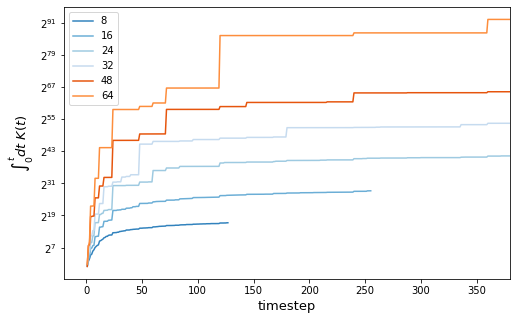

In [58]:
directory = 'sff'
Ls = [8,16,24,32,48,64]
MAX_Ts = [16,16,16,16,8,8]

plt.figure(figsize=(8,5))

for i in range(0,len(Ls)):
    L = Ls[i]
    MAX_T = MAX_Ts[i] * L
    
    infile = open(directory + '/L' + str(L) + '_evol' + str(MAX_T//L), 'rb')
    n_evecs_t, allphase1 = pickle.load(infile)
    infile.close()
    
    ts = np.arange(MAX_T)
    ts = ts[1:]
    plt.plot(ts, np.cumsum(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1)), '-')
# plt.plot(ts[50:], ts[50:]*2**10, color='black', linestyle='--', alpha=0.7)
# plt.plot(ts, ts*2**20.4, color='black', linestyle='--', alpha=0.7)
# plt.plot(ts, ts*2**32.91, color='black', linestyle='--', alpha=0.7)
# plt.plot(ts, ts*2**45.93, color='black', linestyle='--', alpha=0.7)
# plt.plot(ts, ts*2**83.82, color='black', linestyle='--', alpha=0.7)

plt.yscale('log', basey=2)
plt.legend(Ls)
plt.xlabel('timestep', fontsize=13)
plt.xlim([-20,380])
plt.ylabel(r'$\int_0^t dt \ K(t)$', fontsize=13)

plt.savefig('fig_sffcumul.pdf')

In [18]:
def sff_summary(n_evecs_t, allphase1, startfrom=30):

    print('------------------------------------------------------------')
    
    print('L = ', L, ' with ', n_evecs_t.shape[1], ' circuit realisations')
    
    print('size of the hilbert space, 2^L', 2**L) # state vector of length L for L sites 
    print('square of size of hilbert space', 4**L)
    print('number of pauli strings, 4^L', 4**L) # number of pauli strings (L locations with {I,X,Y,Z} for each, 4^L = 2^(2L))

    print()

    print('time 0')
    print('n_evecs_t(0) = ', int(np.mean(n_evecs_t[0])))
    print('SFF(0) = ', int(2**np.mean(n_evecs_t[0])))

    print()

    print('late times')
    
    # mean of post ramp SFF
    print('theor. SFF for unitary (size of hilbert space) %d = 2^%d' %(2**L, L))
    print('obser. SFF %.2f = 2^%.2f' % (np.mean(np.mean(2**n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1)), 
         np.log2(np.mean(np.mean(2**n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1)))))
    print('log mean of above %.2f' % (np.mean(np.mean(n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1))))
    print('obser. std. SFF %.2f = 2^%.2f' % (np.std(np.mean(2**n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1)), 
         np.log2(np.std(np.mean(2**n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1)))))
    print('mean number of 1-eigvecs %.2f' % (np.mean(np.mean(n_evecs_t[startfrom:],axis=1))))
    print('std number of 1-eigvecs %.2f' % (np.std(np.mean(n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1))))

    print('------------------------------------------------------------')

In [25]:
directory = 'sff'
directory = 'sff_old'

L = 8
MAX_T = 16*L

# L = 16
# MAX_T = 16*L

# L = 24
# MAX_T = 16*L

L = 32
MAX_T = 16*L

# L = 48
# MAX_T = 8*L

# L = 64
# MAX_T = 8*L

infile = open(directory + '/L' + str(L) + '_evol' + str(MAX_T//L), 'rb')
n_evecs_t, allphase1 = pickle.load(infile)
infile.close()

ts = np.arange(MAX_T)
ts = ts[1:]

sff_summary(n_evecs_t, allphase1)

------------------------------------------------------------
L =  32  with  750  circuit realisations
size of the hilbert space, 2^L 4294967296
square of size of hilbert space 18446744073709551616
number of pauli strings, 4^L 18446744073709551616

time 0
n_evecs_t(0) =  64
SFF(0) =  18446744073709551616

late times
theor. SFF for unitary (size of hilbert space) 4294967296 = 2^32
obser. SFF 158509845540.62 = 2^37.21
log mean of above 2.65
obser. std. SFF 1899197706852.46 = 2^40.79
mean number of 1-eigvecs 10.01
std number of 1-eigvecs 3.72
------------------------------------------------------------


In [22]:
import matplotlib as mpl
# go here to get colourmaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20c.colors)

In [9]:
# PRINTOUT

print('L = ', L)
print('size of the hilbert space, 2^L', 2**L) # state vector of length L for L sites 
print('square of size of hilbert space', 4**L)
print('number of pauli strings, 4^L', 4**L) # number of pauli strings (L locations with {I,X,Y,Z} for each, 4^L = 2^(2L))

print()

print('time 0')
print('n_evecs_t(0) = ', int(np.mean(n_evecs_t[0])))
print('SFF(0) = ', int(2**np.mean(n_evecs_t[0])))

print()

print('late times')

startfrom = 30

# mean of post ramp SFF
print('theor. SFF for unitary (size of hilbert space) %d = 2^%d' %(2**L, L))
print('obser. SFF %.2f = 2^%.2f' % (np.mean(np.mean(2**n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1)), 
     np.log2(np.mean(np.mean(2**n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1)))))
print('log mean of above %.2f' % (np.mean(np.mean(n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1))))
print('obser. std. SFF %.2f = 2^%.2f' % (np.std(np.mean(2**n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1)), 
     np.log2(np.std(np.mean(2**n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1)))))
print('mean number of 1-eigvecs %.2f' % (np.mean(np.mean(n_evecs_t[startfrom:],axis=1))))
print('std number of 1-eigvecs %.2f' % (np.std(np.mean(n_evecs_t[startfrom:] * allphase1[startfrom:],axis=1))))


L =  16
size of the hilbert space, 2^L 65536
square of size of hilbert space 4294967296
number of pauli strings, 4^L 4294967296

time 0
n_evecs_t(0) =  32
SFF(0) =  4294967296

late times
theor. SFF for unitary (size of hilbert space) 65536 = 2^16
obser. SFF 1398134.57 = 2^20.42
log mean of above 2.11
obser. std. SFF 5162749.08 = 2^22.30
mean number of 1-eigvecs 4.09
std number of 1-eigvecs 1.97


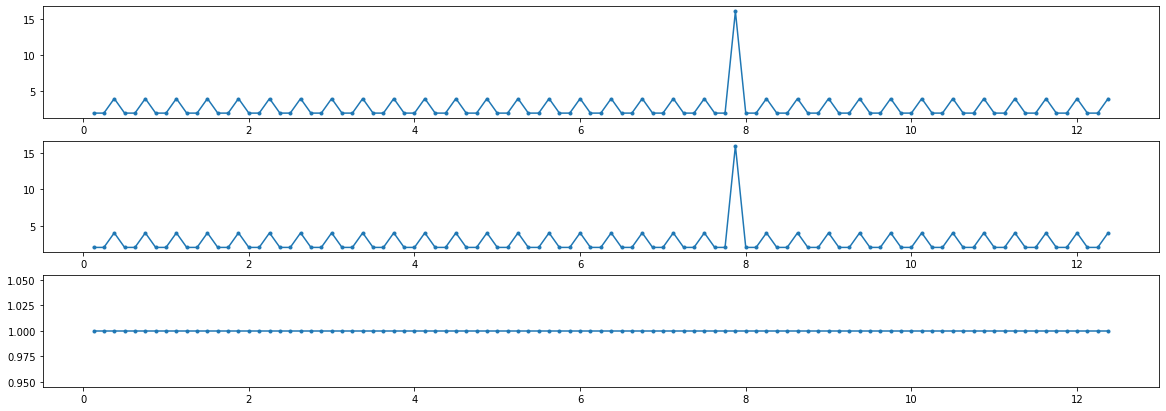

In [59]:
# examine a particular circuit

circ = 5

cutoff = 100
n_evecs_t = n_evecs_t[:cutoff]
allphase1 = allphase1[:cutoff]
ts = ts[:cutoff-1]

plt.figure(figsize=(20,7))
plt.subplot(3,1,1)
plt.plot(ts, n_evecs_t[1:,circ] * allphase1[1:,circ], '.-')
plt.subplot(3,1,2)
plt.plot(ts, n_evecs_t[1:,circ], '.-')
plt.subplot(3,1,3)
plt.plot(ts, allphase1[1:,circ], '.-')

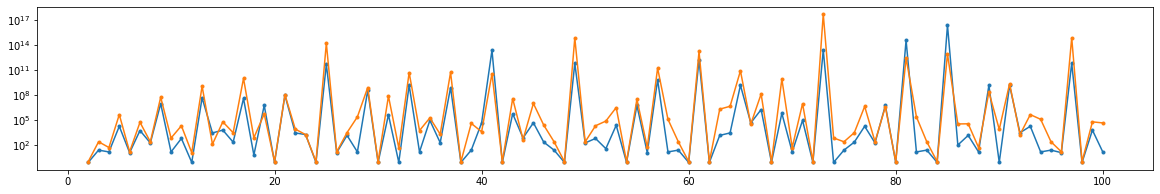

In [4]:
# compare two divisions of the sample

split = len(allphase1)//2

plt.figure(figsize=(20,3))
plt.semilogy(ts[1:100], np.mean(2**n_evecs_t[1:100,:split] * allphase1[1:100,:split],axis=1), '.-')
plt.semilogy(ts[1:100], np.mean(2**n_evecs_t[1:100,split:] * allphase1[1:100,split:],axis=1), '.-')

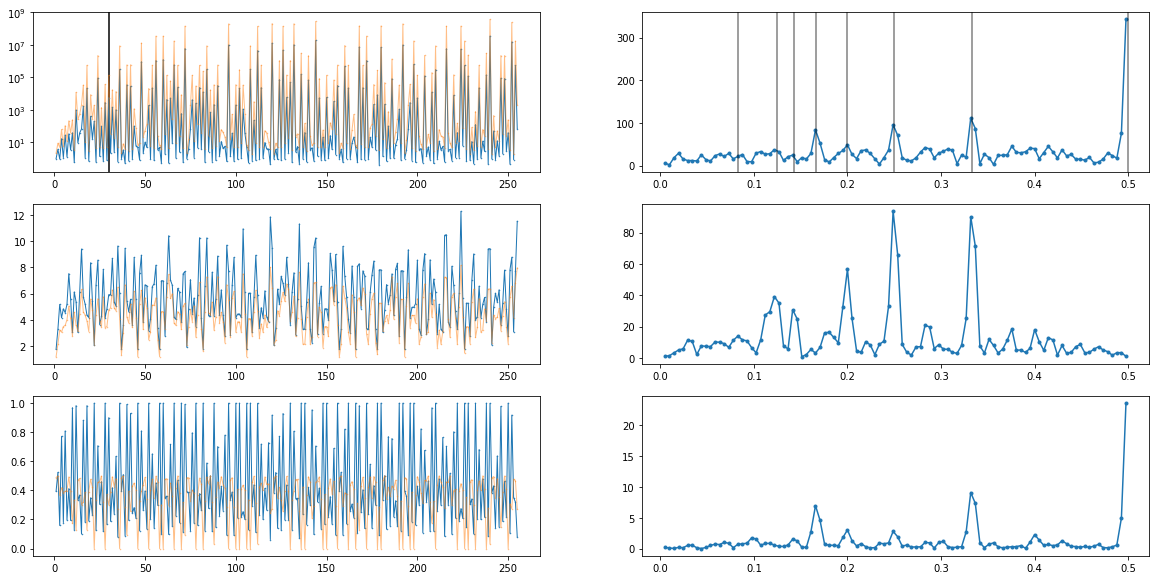

In [6]:
peaks = [1/2,1/3,1/4,1/5,1/6,1/7,1/8,1/12]
show_std = True
mk = 1

# cutoff = 200
# n_evecs_t = n_evecs_t[:cutoff]
# allphase1 = allphase1[:cutoff]
# ts = ts[:cutoff-1]

plt.figure(figsize=(20,10))

# fourier transform of SFF
# product of two things their fourier series is just a sum-ish

startfrom = 50

y = np.log(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1)[startfrom:]) # log of mean SFF
# y = np.mean(n_evecs_t[1:] * allphase1[1:],axis=1)[startfrom:] # mean of log SFF
freqs, psd = fft_plot(y,len(y))

plt.subplot(3,2,1)
# plt.axvline(x=L, color='k')
# plt.axvline(x=2*L, color='k')
plt.axvline(x=30, color='k')
plt.semilogy(ts, np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-', linewidth=1, markersize=mk)
if show_std: plt.semilogy(ts, np.std(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-', alpha=0.5, linewidth=1, markersize=mk)
# plt.semilogy(ts,ts)
plt.subplot(3,2,2)
plt.plot(freqs[1:], psd[1:], '.-')
for peak in peaks: plt.axvline(x=peak, color='k', alpha=0.5)


y = np.mean(n_evecs_t[1:],axis=1)[startfrom:]
freqs, psd = fft_plot(y,len(y))

plt.subplot(3,2,3)
plt.plot(ts, np.mean(n_evecs_t[1:],axis=1), '.-', linewidth=1, markersize=mk)
if show_std: plt.plot(ts, np.std(n_evecs_t[1:],axis=1), '.-', alpha=0.5, linewidth=1, markersize=mk)
plt.subplot(3,2,4)
plt.plot(freqs[1:], psd[1:], '.-')


y = np.mean(allphase1[1:],axis=1)[startfrom:]
freqs, psd = fft_plot(y,len(y))

plt.subplot(3,2,5)
plt.plot(ts, np.mean(allphase1[1:],axis=1), '.-', linewidth=1, markersize=mk)
if show_std: plt.plot(ts, np.std(allphase1[1:],axis=1), '.-', alpha=0.5, linewidth=1, markersize=mk)
plt.subplot(3,2,6)
plt.plot(freqs[1:], psd[1:], '.-')

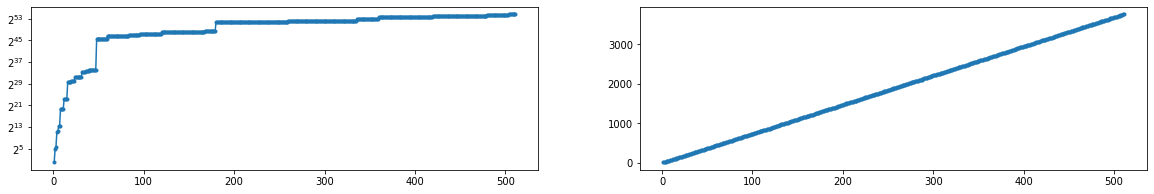

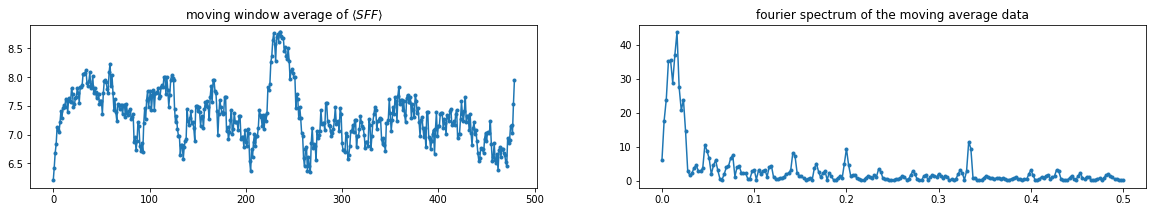

In [12]:
# cumulative sum

plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.plot(ts, np.cumsum(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1)), '.-')
plt.yscale('log', basey=2)
plt.subplot(1,2,2)
plt.plot(ts, np.cumsum(np.mean(n_evecs_t[1:],axis=1)), '.-')
plt.show()

# moving window of SFF

window = L
y = np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1)

plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
ma = 2**np.convolve(np.log(y), np.ones((window,))/window, mode='valid')
plt.plot(np.log(ma), '.-')
# plt.xlim([0,100])
plt.title('moving window average of ' + r'$\langle SFF \rangle$')

plt.subplot(1,2,2)
startfrom = 50
freqs, psd = fft_plot(np.log(ma[startfrom:]), len(ma[startfrom:]))
plt.plot(freqs, psd, '.-')
plt.title('fourier spectrum of the moving average data')
plt.show()

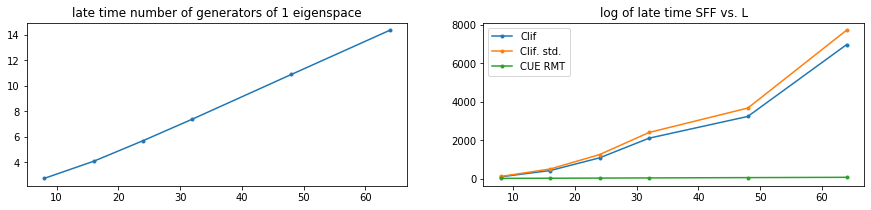

In [26]:
Ls = [8,16,24,32,48,64]
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(Ls, [2.75,4.09,5.70,7.39,10.88,14.35], '.-')
plt.title('late time number of generators of 1 eigenspace')
plt.subplot(1,2,2)
plt.plot(Ls, np.power([9.54,20.42,32.83,45.83,56.86,83.51],2), '.-')
plt.plot(Ls, np.power([10.47, 22.3, 35.33, 48.96, 60.58, 87.90],2), '.-')
plt.plot(Ls, Ls, '.-')
plt.legend(['Clif', 'Clif. std.', 'CUE RMT'])
plt.title('log of late time SFF vs. L')
plt.show()

# GENERATING FIGURES

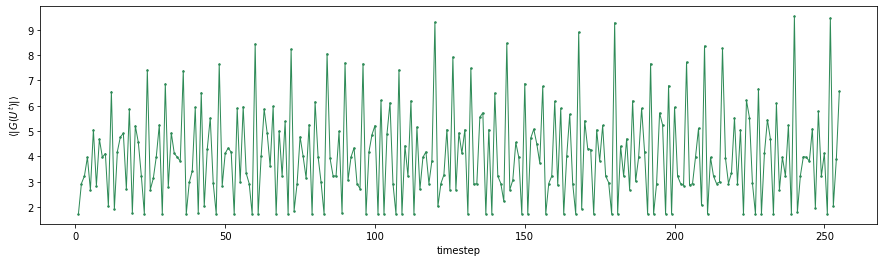

In [67]:
# cutoff = 30
# n_evecs_t = n_evecs_t[:cutoff]
# allphase1 = allphase1[:cutoff]
# ts = ts[:cutoff-1]

# fig, ax = plt.subplots(figsize=(15,4))
# ax.semilogy(ts, np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-', 
#              color='seagreen', linewidth=1, markersize=3)
# # ax.semilogy(ts, np.cumsum(2**np.mean(n_evecs_t[1:] * allphase1[1:],axis=1)) / np.arange(1,len(allphase1)), '.-')
# ax.set_xlabel('timestep')
# ax.set_ylabel(r'$K(t)$')
# left, bottom, width, height = [0.68, 0.42, 0.2, 0.4]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.semilogy(ts[:40], np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1)[:40], '.-', color='seagreen')
# plt.savefig('fig_sff_L16.pdf')

plt.figure(figsize=(15,4))
plt.plot(ts, np.mean(n_evecs_t[1:],axis=1), '.-',  color='seagreen', linewidth=1, markersize=3)
plt.xlabel('timestep')
plt.ylabel(r'$\langle |G(U^t)| \rangle$')
# plt.savefig('fig_evecs_L16.pdf')

# fig, ax = plt.subplots(figsize=(15,4))
# ax.plot(ts, np.mean(allphase1[1:],axis=1), '.-',  color='seagreen', linewidth=1, markersize=3, alpha=0.5)
# ax.set_xlabel('timestep')
# ax.set_ylabel('fraction of circuits with all +1 phase generators')
# left, bottom, width, height = [0.68, 0.42, 0.2, 0.4]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(ts[:40], np.mean(allphase1[1:],axis=1)[:40], '.-', color='seagreen')
# plt.savefig('fig_allphase1_L16.pdf')

Text(0, 0.5, 'amplitude spectral density')

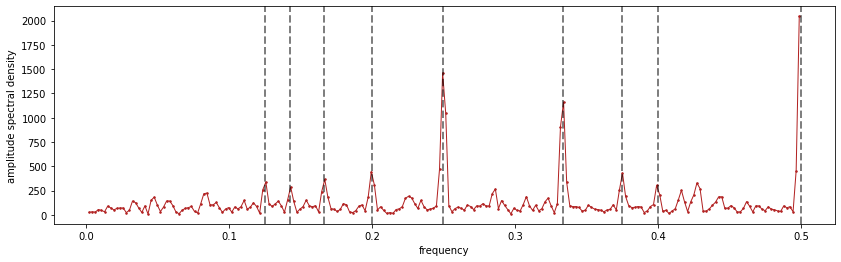

In [49]:
startfrom = 50

plt.figure(figsize=(14,4))
y = np.log2(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1)[startfrom:])
freqs, psd = fft_plot(y,len(y))
plt.plot(freqs[1:], psd[1:], '.-', color='firebrick', linewidth=1, markersize=3)
for peak in [1/2,1/3,1/4,1/5,1/6,1/7,1/8,2/5,3/8]: # 3/8,3/7 are prominent but omitted
    plt.axvline(x=peak, linestyle='--', color='k', alpha=0.5, linewidth=2)
plt.xlabel('frequency')
plt.ylabel('amplitude spectral density')
# plt.savefig('fig_sff_ft.pdf')

# plt.figure(figsize=(14,4))
# y = np.mean(n_evecs_t[1:],axis=1)[startfrom:]
# freqs, psd = fft_plot(y,len(y))
# plt.plot(freqs[1:], psd[1:], '.-', color='firebrick', linewidth=1, markersize=3)
# for peak in [1/2,1/3,1/4,1/5,1/6,1/7,1/8,2/5,3/8,1/9,2/9,4/9,2/7,3/7]:
#     plt.axvline(x=peak, linestyle='--', color='k', alpha=0.5, linewidth=2)
# plt.xlabel('frequency')
# plt.ylabel('amplitude spectral density')
# plt.savefig('fig_evecs_ft.pdf')

# plt.figure(figsize=(14,4))
# y = np.mean(allphase1[1:],axis=1)[startfrom:]
# freqs, psd = fft_plot(y,len(y))
# plt.plot(freqs[1:], psd[1:], '.-', color='firebrick', linewidth=1, markersize=3)
# for peak in [1/2,1/4,1/8,1/16,3/8,3/16,5/16,7/16]:
#     plt.axvline(x=peak, linestyle='--', color='k', alpha=0.5, linewidth=2)
# plt.xlabel('frequency')
# plt.ylabel('amplitude spectral density')
# plt.savefig('fig_allphase1_ft.pdf')

# old versions

In [56]:
L = 6
n_circuits = 1000
MAX_T = 4*L
directory = 'sff_localruns'

circuits = choice(np.arange(576,len(allGates)), (L,n_circuits))
n_evecs_t = np.zeros((MAX_T,n_circuits))
allphase1 = np.full((MAX_T,n_circuits), True)

for circuit_ind in tqdm(range(n_circuits)):
    floquet_array = circuits[:,circuit_ind]

    pauli_strings = np.identity(2*L, dtype='int8')

    for timesteps in range(MAX_T):
        for t in range(timesteps):
            floquet = lst_gen(floquet_array)
            for i in range(0, L ,2):
                gate = allGates[next(floquet)]
                twoQubitClif(pauli_strings, gate, i, i+1)
            for i in range(1, L+1, 2):
                gate = allGates[next(floquet)]
                twoQubitClif(pauli_strings, gate, i, (i+1)%L)

        gate = pauli_strings


        eig1 = (gate - np.eye(2*L, dtype='int8')) % 2
        system = np.vstack((eig1, np.identity(2*L, dtype='int8')))
        system_solved = gf2RowRed(system.T.copy()).T

        n_evecs = 0
        eigvecs = []
        for col in range(2*L):
            if np.sum(system_solved[:2*L,col]) == 0:
                n_evecs += 1
                eigvec = system_solved[2*L:,col]
                eigvecs.append(eigvec)
                if not np.array_equal((gate @ eigvec) % 2, eigvec):
                    print(col, eigvec, (gate @ eigvec) % 2)
                    raise Exception()
        n_evecs_t[timesteps,circuit_ind] = n_evecs
        
        for eigvec in eigvecs:
            ps = np.hstack((eigvec, [0]))
            
            for t in range(timesteps):
                floquet = lst_gen(floquet_array)
                for i in range(0, L ,2):
                    gate = allGates[next(floquet)]
                    twoQubitClif_ps(ps, gate, i, i+1)
                for i in range(1, L+1, 2):
                    gate = allGates[next(floquet)]
                    twoQubitClif_ps(ps, gate, i, (i+1)%L)

            if (ps[-1] != 0):
                allphase1[timesteps,circuit_ind] = False
                break

outfile = open(directory + '/L' + str(L) + '_maxt' + str(MAX_T), 'wb')
pickle.dump(np.stack((n_evecs_t, allphase1)), outfile)
outfile.close()

100%|██████████| 1000/1000 [00:57<00:00, 17.32it/s]


L= 16
50  circuit realisations


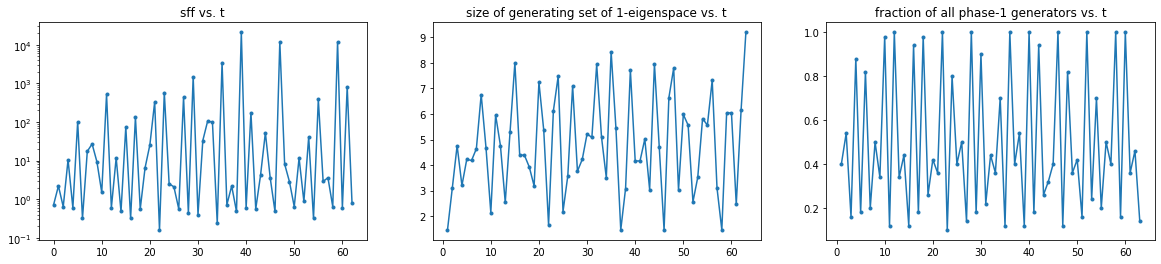

In [53]:
ts = np.arange(MAX_T)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.semilogy(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 12
100  circuit realisations


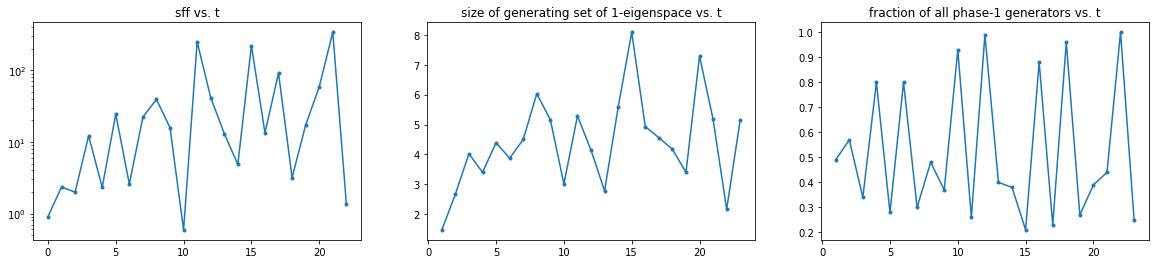

In [37]:
ts = np.arange(MAX_T)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.semilogy(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 8
100  circuit realisations


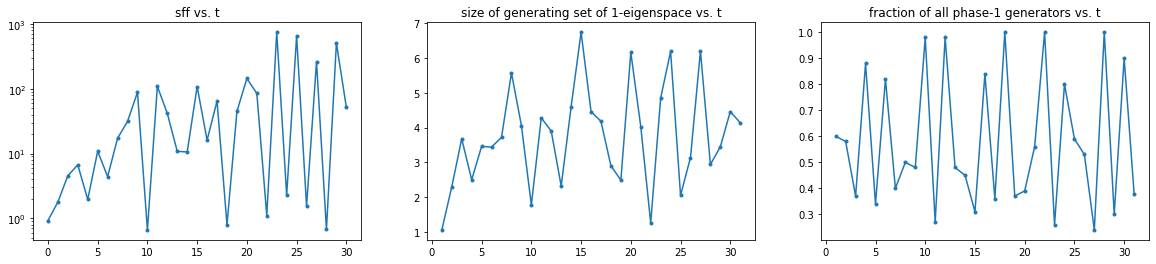

In [55]:
ts = np.arange(MAX_T)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.semilogy(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 6
1000  circuit realisations


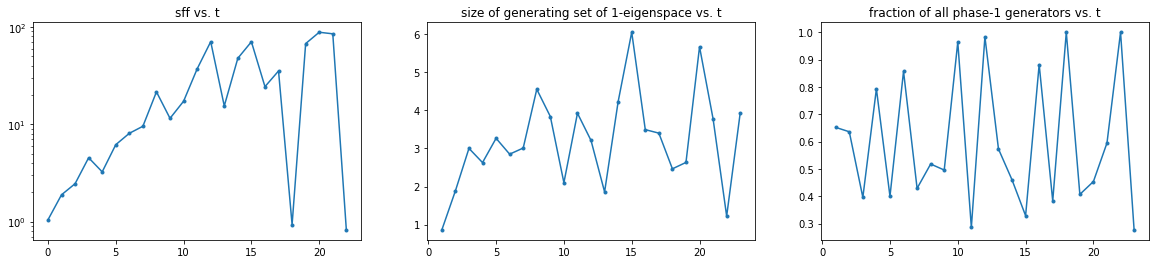

In [57]:
ts = np.arange(MAX_T)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.semilogy(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

# old local runs - incorrect allGates

L= 48
10  circuit realisations


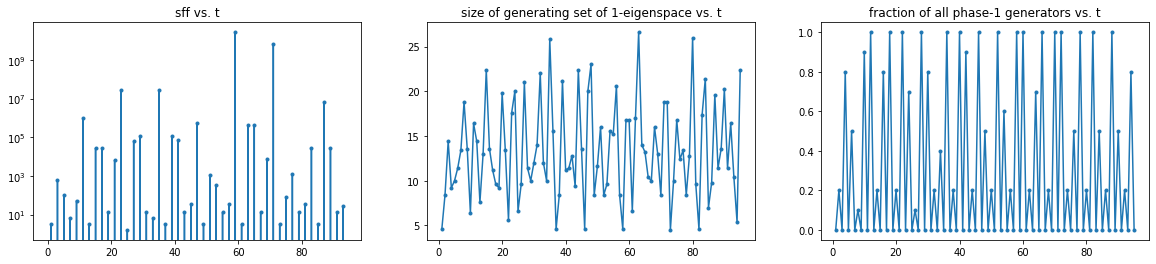

In [70]:
ts = np.arange(0,2*L)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.semilogy(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 8
200  circuit realisations


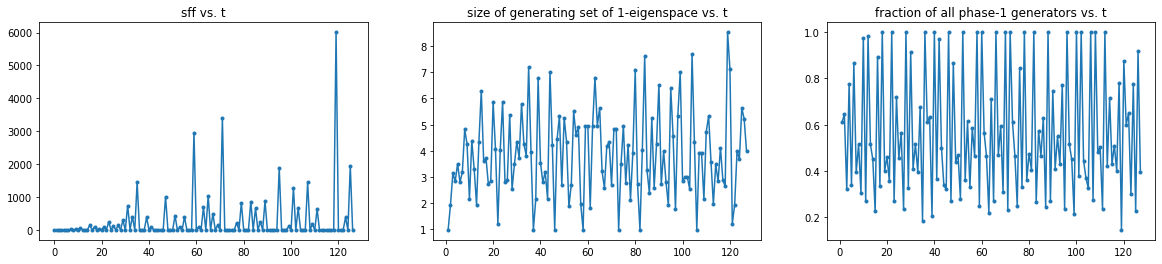

In [14]:
ts = np.arange(0,MAX_T)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.plot(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 8
200  circuit realisations


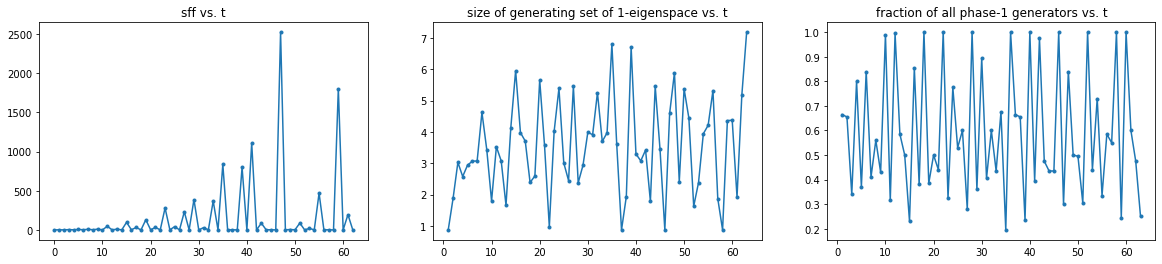

In [9]:
ts = np.arange(0,8*L)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.plot(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 8 1000  circuit realisations


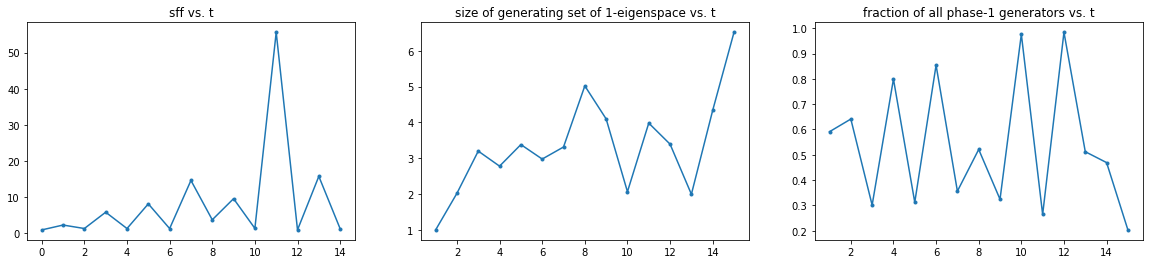

In [59]:
ts = np.arange(0,2*L)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.plot(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 10
1000  circuit realisations


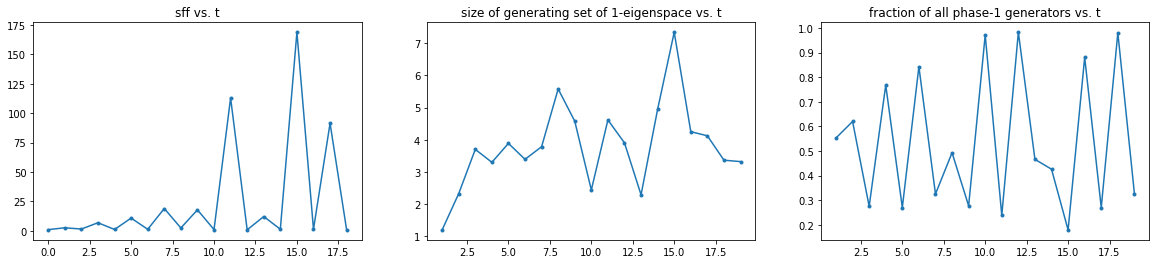

In [61]:
ts = np.arange(0,2*L)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.plot(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 12
100  circuit realisations


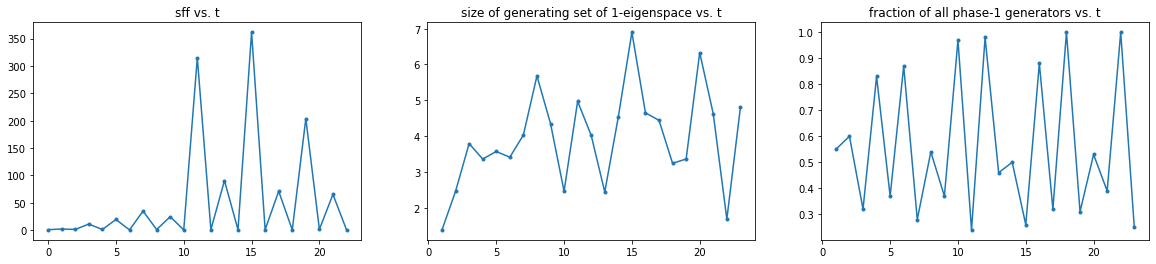

In [63]:
ts = np.arange(0,2*L)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.plot(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

L= 12
1000  circuit realisations


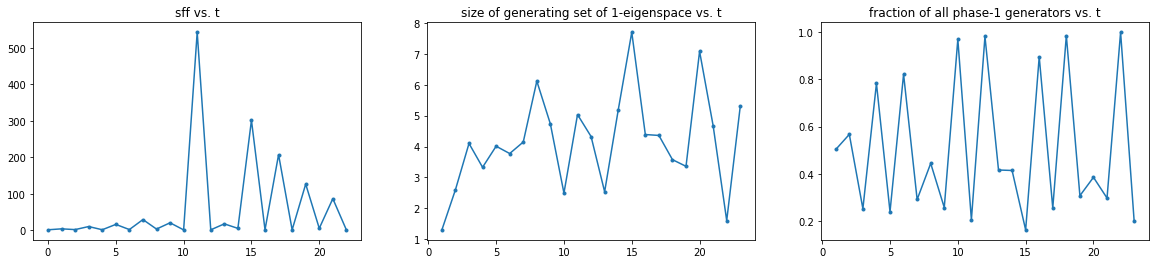

In [65]:
ts = np.arange(0,2*L)
print('L=', L)
print(n_circuits, ' circuit realisations')

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('sff vs. t')
plt.plot(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.title('size of generating set of 1-eigenspace vs. t')
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.title('fraction of all phase-1 generators vs. t')
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')
plt.show()

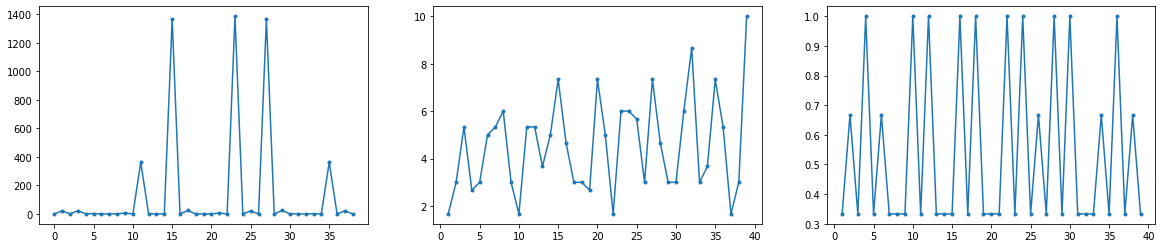

In [41]:
ts = np.arange(0,2*L)

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(np.mean(2**n_evecs_t[1:] * allphase1[1:],axis=1), '.-')
plt.subplot(1,3,2)
plt.plot(ts[1:], np.mean(n_evecs_t[1:],axis=1), '.-')
plt.subplot(1,3,3)
plt.plot(ts[1:], np.mean(allphase1[1:],axis=1), '.-')

[20.     1.12   2.384  3.828  2.988  3.744  3.436  3.632  5.944  4.538
  2.276  4.884  4.     2.176  4.806  7.31   3.952  4.012  3.326  2.998]


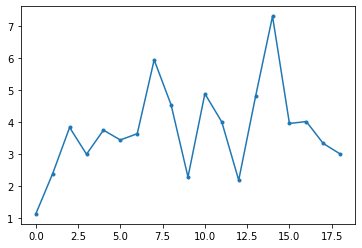

In [198]:
plt.plot(np.mean(n_evecs_t,axis=1)[1:], '.-')
print(np.mean(n_evecs_t,axis=1))

[16.     1.006  2.142  3.418  2.76   3.502  3.242  3.464  5.13   4.14
  2.314  4.68   3.488  2.064  4.618  6.666]


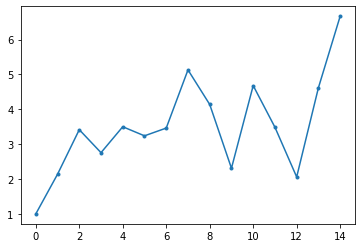

In [193]:
plt.plot(np.mean(n_evecs_t,axis=1)[1:], '.-')
print(np.mean(n_evecs_t,axis=1))

[16.     0.928  1.994  3.094  2.706  3.34   3.     3.13   4.772  3.992
  2.026  3.894  3.258  1.9    4.338  6.366]


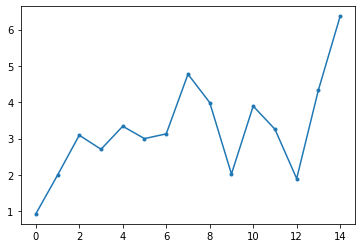

In [191]:
plt.plot(np.mean(n_evecs_t,axis=1)[1:], '.-')
print(np.mean(n_evecs_t,axis=1))

Text(0.5, 1.0, 'number of generators of 1-eigenspace vs. time, L=8, 1e4 realisations')

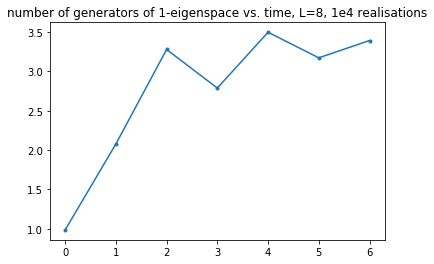

In [145]:
plt.plot(np.mean(n_evecs_t,axis=1)[1:], '.-')
plt.title('number of generators of 1-eigenspace vs. time, L=8, 1e4 realisations')